### Imports

In [104]:
import pandas as pd
import nltk, re, string
import numpy as np
from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import preprocessing
from sklearn import svm
from nltk.corpus import stopwords

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import itertools
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import re, collections
from nltk.corpus import words as w
import pickle
from nltk.corpus import *
from nltk.collocations import *
from string import punctuation
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

In [28]:
%matplotlib inline

## Algorithm used

* Preprocess data, tokenize and lemmatize
* Feature extraction - TF-IDF, word2vec and custom features added
* Train on Linear SVM
* Fit data and check accuracy

### Preprocess Data

Read the csv file and make a dataframe.
- For training: Randomize and Divide it into 80:20 partitions

In [15]:
def load_Dataset(run="train"):
    df = pd.read_csv("train.csv")
    df = df[df["Comment"].notnull()]
    df.apply(np.random.permutation)
    if run=="train":
        df_train = df[:round(0.8*len(df))]
        df_test = df[round(0.8*len(df)):]
    elif run=="test":
        df_train = df
        df_test = pd.read_csv("test_with_solutions.csv")
    return df_train, df_test

### Tokenization

This function takes a text and does the following to return the tokens:
* Use nltk's TweetTokenizer to get tokens
* Use wordNetLemmatizer for lemmatization
* Use porterStemmer to stem the resulting tokens

In [16]:
def words(text):
    return re.findall('[a-z]+', text.lower())

def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1   
    return model

with open("big.txt", "r") as big:
    word_corpus = big.read()
for word in w.words():
    word_corpus += word
    

NWORDS = train(words(word_corpus))
with open("list_of_abuses.txt", "r") as abuse_list:
    abuses = abuse_list.read().split()
    for abuse in abuses:
        NWORDS[abuse] = 100

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
#     print(word)
    s = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [a + b[1:] for a, b in s if b]
    transposes = [a + b[1] + b[0] + b[2:] for a, b in s if len(b)>1]
    replaces   = [a + c + b[1:] for a, b in s for c in alphabet if b]
    inserts    = [a + c + b     for a, b in s for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)

def known(words):
    try:
        return [int(w) for w in words] #to take care of purely numeric words
    except:
        return set(w for w in words if w.lower() in NWORDS)

def correct(word):
    if word[0] not in alphabet: 
        return word
    else:
        word = re.sub(r'(.)\1+', r'\1\1', word)
        candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
        return max(candidates, key=NWORDS.get)

In [17]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w!@#$%^&*]+)', # To group symbols together
    r'(?:[\w_]+)', # other words
    
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    tokens = tokens_re.findall(s)
    for i in range(len(tokens)):
        clean_token = correct(tokens[i])
        tokens[i] = clean_token
    return tokens
 
def preprocess(word, lowercase=False):
    tokens = tokenize(word)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

### Tokenization

This function takes a text and does the following to return the tokens:
* Custom tokenizer we came up with as above did not work well and we ended up using the tweettokenizer
* Use nltk's TweetTokenizer to get tokens
* Use wordNetLemmatizer for lemmatization
* Use porterStemmer to stem the resulting tokens

In [18]:
def build_tokens(text):
    tweetTokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tweetTokenizer.tokenize(text)
    #tokens = preprocess(text, lowercase=True)
    tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens]
    #tokens= [nltk.PorterStemmer().stem(token) for token in tokens]
    return tokens


Stemming and custom preprocessing reduced the accuracy. Tweettokenizer worked better. We also realized that making the tweets into lower case resulted in loss of emphasis and ended up preserving the case of the text.

## Pipeline and Adding Custom features

#### Adding additional features

This class does the following:
* Few custom features are added
* percentage of bad words in a sentence as listed in the bad words file
* compound, negative and positive values from vader sentiment analysis
* insults directed at a person using you are "bad_word" as a feature and not containing the word "not"

Ref: http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

In [37]:
class AdditionalFeatureExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def get_feature_names(self):
        return (['vader_compound','vader_neg','vader_pos','vader_neu','ur_bad'])
    
    def num_bad(self, df):
       
        #get number of words in each sentence
        with open("list_of_abuses.txt", "r") as abuse_list:
             abuses = abuse_list.read().split("\n")
        num_words = [len(word) for word in df]
        
        #get percent of abusive words in each sentence
        num_abuses = 0
        for abuse in abuses:
            num_abuses += 1
        # number of badwords in list of abuses
        num_bad = [np.sum([word.lower().count(abuse) for abuse in abuses])
                                            for word in df]
        norm_bad = np.array(num_bad) / np.array(num_words, dtype=np.float)
        return norm_bad

    def ur_bad(self, df):
        
        #look for you are "bad words" in text
        with open("list_of_abuses.txt", "r") as abuse_list:
             abuses = abuse_list.read().split("\n")
        ur_bad_bool = []
        for sentence in df:
            abuse_found = False
            for words in abuses:
                abuse = r'(\b%s\b)' %words
                if (re.findall(r"\byou are\b",sentence.lower()) != []) and (re.findall(abuse,sentence.lower()) != []):
                    if (re.findall(r"\bnot\b",sentence.lower()) == []):
                        ur_bad_bool.append(True)
                        abuse_found = True
                        break
                elif (re.findall(r"\bur\b",sentence.lower()) != []) and (re.findall(abuse,sentence.lower()) != []):
                    if (re.findall(r"\bnot\b",sentence.lower()) == []):
                        ur_bad_bool.append(True)
                        abuse_found = True
                        break
                elif (re.findall(r"\byour\b",sentence.lower()) != []) and (re.findall(abuse,sentence.lower()) != []):
                    if (re.findall(r"\bnot\b",sentence.lower()) == []):
                        ur_bad_bool.append(True)
                        abuse_found = True
                        break
                elif (re.findall(r"\byou're\b",sentence.lower()) != []) and (re.findall(abuse,sentence.lower()) != []):
                    if (re.findall(r"\bnot\b",sentence.lower()) == []):
                        ur_bad_bool.append(True)
                        abuse_found = True
                        break
                elif (re.findall(r"\bu r\b",sentence.lower()) != []) and (re.findall(abuse,sentence.lower()) != []):
                    if (re.findall(r"\bnot\b",sentence.lower()) == []):
                        ur_bad_bool.append(True)
                        abuse_found = True
                        break
            if abuse_found == False:
                ur_bad_bool.append(False)            
        return ur_bad_bool
    
    def num_words(self, df):
        
        #get number of words in each sentence
        num_words = [len(word) for word in df]
        return num_words
    
    def vader_helper(self, df):
        
        #vader analysis
        sid = SentimentIntensityAnalyzer()
        vader_feature = []
        for sentence in df:
            ss = sid.polarity_scores(sentence)
            vader_feature.append(ss['compound'])
        return vader_feature
    
    def vader_helper_neg(self, df):
        
        #vader analysis
        sid = SentimentIntensityAnalyzer()
        vader_feature = []
        for sentence in df:
            ss = sid.polarity_scores(sentence)
            vader_feature.append(ss['neg'])
        return vader_feature
    
    def vader_helper_neu(self, df):
       
        #vader analysis
        sid = SentimentIntensityAnalyzer()
        vader_feature = []
        for sentence in df:
            ss = sid.polarity_scores(sentence)
            vader_feature.append(ss['neu'])
        return vader_feature
    
    def vader_helper_pos(self, df):
        #vader analysis
        sid = SentimentIntensityAnalyzer()
        vader_feature = []
        for sentence in df:
            ss = sid.polarity_scores(sentence)
            vader_feature.append(ss['pos'])
        return vader_feature
    
    def transform(self, df, y=None):
        
        #add all the features to an array
        X = np.array([self.vader_helper(df),self.vader_helper_pos(df),self.vader_helper_neg(df),self.vader_helper_neu(df),self.ur_bad(df)]).T
        if not hasattr(self, 'scalar'):
            self.scalar = preprocessing.StandardScaler().fit(X)
        return self.scalar.transform(X)      

    def fit(self, df, y=None):
        return self

### This Function does the following:
* To make Tweet Vector we take all tokens in a tweet and see if we have a word2vec for that word. We keep adding all these word vectors and take average to get a tweet vector
* We are making our entire tweet into a 200 dimensional vector
* We take our tfidf and word vectors and append them to get the final vector. Since these are of different scale, we are normalising the final vector

In [38]:
class Word2VecFeatureExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def get_feature_names(self):
        return (['word2vec'])
    
    def make_tweetVector(self, df_comments):
        learned_word_vectors,learned_dictionary = pickle.load( open( "glove_twitter_200d.pkl", "rb" ) ) 
        tweetVector = np.zeros((len(df_comments),200),dtype='float')
        count = 0 
        for text in df_comments:
            valids= 0
            tokens = build_tokens(text)
            rowVector = np.zeros(200,)
            for token in tokens:
                if token not in learned_dictionary:
                    continue
                else:
                    valids+=1
                    vec = learned_word_vectors[learned_dictionary[token.lower()]]
                    rowVector = np.add(rowVector,vec)
            tweetVector[count] = rowVector/valids
            count+=1
        return tweetVector
    
    def transform(self, df, y=None):     
        #add both the features to an array
        X = np.array(self.make_tweetVector(df))
        if not hasattr(self, 'scalar'):
            self.scalar = preprocessing.StandardScaler().fit(X)
        return self.scalar.transform(X)      

    def fit(self, df, y=None):
        return self

The custom features and Word2Vec features are stacked along with the features got from TF-IDF char and word analyzer. 

Most of the stop words could influence our results, so we removed only the articles. We found that considering 6-grams gave the best accuracy.

In [206]:
stopwords = ['the','a','an']
def all_features():
    features = []
    custom_features = AdditionalFeatureExtractor() # this class includes my custom features 
    
    vect = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,6), analyzer= "char", stop_words = stopwords, tokenizer= build_tokens)
    vect1 = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,6), analyzer= "word",stop_words = stopwords, tokenizer= build_tokens)
    word2vec = Word2VecFeatureExtractor()
    features.append(('ngram', vect))
    features.append(('ngram1', vect1))
    features.append(('word2vec',word2vec))
    features.append(('custom_features', custom_features))
    return features

Using all the features rather than selected number of features gave a better accuracy.

SVM Linear classifier gives the best score - better than ensemble

In [207]:
def all_classifiers():
    #clf1 = linear_model.LogisticRegression(C=3, max_iter=3000, tol=1e-8)
    clf3 = svm.SVC(kernel='linear', gamma=1.2, C=1, decision_function_shape="ovo",probability=True)
    #clf4 = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet',alpha=0.001, n_jobs=-1)
    #eclf = VotingClassifier(estimators=[('lr',clf1),('svm_rbf',clf3), ('sgd' , clf4)], voting="soft")
    return clf3

### Pipeline

In [208]:
from sklearn.feature_selection import SelectPercentile
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
best_clf = Pipeline([
    ('all', FeatureUnion(all_features())),
    ('linear',all_classifiers()),
    ])

The above pipeline calls the feature function and creates a featureunion of all the features discussed above.

### Training and predicting on split test set

In [209]:
df_train, df_test = load_Dataset()

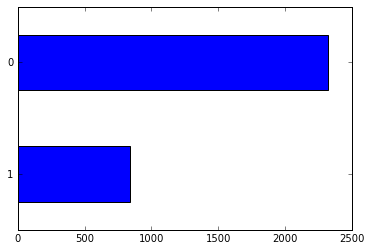

In [210]:
category_counts = df_train["Insult"].value_counts(ascending=True)
category_counts.plot(kind='barh')

In [211]:
best_clf.fit(df_train.Comment,df_train.Insult)
predicted = best_clf.predict(df_test.Comment)


In [212]:
accuracy_score(df_test.Insult,predicted)

0.83776932826362482

### Classification report

In [213]:
class_labels = np.sort(df_train.Insult.unique())
lables = [str(i) for i in class_labels]
print(classification_report(df_test.Insult, predicted, target_names=lables))

             precision    recall  f1-score   support

          0       0.88      0.90      0.89       578
          1       0.70      0.68      0.69       211

avg / total       0.84      0.84      0.84       789



Testing on random sentences

In [214]:
best_clf.predict_proba(["You are a nobody"])

array([[ 0.29705442,  0.70294558]])

In [215]:
best_clf.predict_proba(["what the fuck is that"])

array([[ 0.85754458,  0.14245542]])

### Testing on validation set

In [216]:
df_train1, df_test1 = load_Dataset("test")

In [217]:
predictions1 = best_clf.predict(df_test1.Comment)

In [218]:
accuracy_score(df_test1.Insult,predictions1)

0.84699659992444276

In [219]:
print(classification_report(df_test1.Insult, predictions1, target_names=lables))

             precision    recall  f1-score   support

          0       0.89      0.91      0.90      1954
          1       0.72      0.68      0.70       693

avg / total       0.84      0.85      0.85      2647



## Function to plot Confusion matrix

This function plots the confusion matrix

In [95]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title, target_names, cmap=plt.cm.coolwarm):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

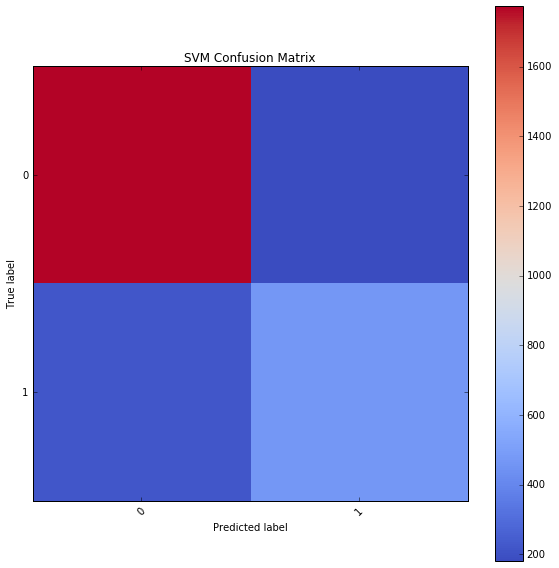

In [97]:
class_labels = np.sort(df_test1.Insult.unique())


nb_cm = confusion_matrix(df_test1.Insult,predictions1)
plot_confusion_matrix(nb_cm, "SVM Confusion Matrix", class_labels)

### Make the model a pickle for GUI use

In [98]:
import pickle

#dup to pickle
with open('model_demo1.pkl', 'wb') as f:
    pickle.dump(best_clf, f)
#Load the model from this pickle later
best_clf = pickle.load(open('model_demo1.pkl','rb'))

# returns confidence score ()
def is_abuse(model,sentence):
    confidence = model.predict_proba([sentence])
    print(confidence)
    return confidence


sentence = "you fuck!"
# calling the function
is_abuse(best_clf,sentence)

[[ 0.01665566  0.98334434]]


array([[ 0.01665566,  0.98334434]])

## Code used for hyperparameters, stratified K-fold and K-means

## GRID SEARCH USING HYPERPARAMETERS

In [186]:
X_train, X_test = df_train.Comment, df_test.Comment
y_train,y_test = df_train.Insult, df_test.Insult

#### Grid Search to tune the hyper-parameters

In [187]:
import warnings
warnings.filterwarnings('ignore')

# Set the parameters by cross-validation
best_clf_hyp = Pipeline([ ('vect', TfidfVectorizer(tokenizer=build_tokens,ngram_range=(1, 6),stop_words = stopwords)),
                     ('clf', svm.SVC(decision_function_shape="ovo",probability=True)), ])

tuned_parameters = [{'clf__kernel': ['rbf'], 'clf__gamma': [1e-3, 1e-4],
                     'clf__C': [1, 10, 100, 1000]},
                    {'clf__kernel': ['linear'], 'clf__C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(best_clf_hyp, tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'clf__C': 1, 'clf__kernel': 'linear'}

Grid scores on development set:

0.367 (+/-0.001) for {'clf__gamma': 0.001, 'clf__C': 1, 'clf__kernel': 'rbf'}
0.367 (+/-0.001) for {'clf__gamma': 0.0001, 'clf__C': 1, 'clf__kernel': 'rbf'}
0.367 (+/-0.001) for {'clf__gamma': 0.001, 'clf__C': 10, 'clf__kernel': 'rbf'}
0.367 (+/-0.001) for {'clf__gamma': 0.0001, 'clf__C': 10, 'clf__kernel': 'rbf'}
0.468 (+/-0.400) for {'clf__gamma': 0.001, 'clf__C': 100, 'clf__kernel': 'rbf'}
0.367 (+/-0.001) for {'clf__gamma': 0.0001, 'clf__C': 100, 'clf__kernel': 'rbf'}
0.776 (+/-0.044) for {'clf__gamma': 0.001, 'clf__C': 1000, 'clf__kernel': 'rbf'}
0.468 (+/-0.400) for {'clf__gamma': 0.0001, 'clf__C': 1000, 'clf__kernel': 'rbf'}
0.786 (+/-0.053) for {'clf__C': 1, 'clf__kernel': 'linear'}
0.776 (+/-0.044) for {'clf__C': 10, 'clf__kernel': 'linear'}
0.776 (+/-0.044) for {'clf__C': 100, 'clf__kernel': 'linear'}
0.776 (+/-0.044)

## Stratified K fold cross validation - not useful

In [142]:
data_set = pd.read_csv("train.csv")

skf = StratifiedKFold(n_splits=4)
accuracy = 0
best_model = None
prediction = None
y = None
for train_index, test_index in skf.split(data_set.Comment,data_set.Insult):
    X_train, X_test = data_set.Comment[train_index], data_set.Comment[test_index]
    y_train,y_test = data_set.Insult[train_index], data_set.Insult[test_index]
    # Drop any resulting nan values
    X_train.dropna(inplace=True)
    y_train.dropna(inplace=True)
    X_test.dropna(inplace=True)
    y_test.dropna(inplace=True)
    # Train model using created datasets
    _ = best_clf.fit(X_train, y_train)
    print('Trained model on new train dataset.')
    # Predict on test
    predicted = best_clf.predict(X_test)
    print('Accuracy on test dataset: ')
    test_accuracy = accuracy_score(y_test,predicted)
    print(test_accuracy)
    
    # Save models and accuracy so that we can use it later
    if (test_accuracy > accuracy):
        accuracy = test_accuracy
        best_model = best_clf
        prediction = predicted
        y = y_test

Trained model on new train dataset.
Accuracy on test dataset: 
0.86032388664
Trained model on new train dataset.
Accuracy on test dataset: 
0.838905775076
Trained model on new train dataset.
Accuracy on test dataset: 
0.844827586207
Trained model on new train dataset.
Accuracy on test dataset: 
0.837728194726


In [143]:
print(classification_report(y, prediction, target_names=lables))

             precision    recall  f1-score   support

          0       0.90      0.91      0.91       725
          1       0.75      0.71      0.73       263

avg / total       0.86      0.86      0.86       988



In [154]:
predictions1 = best_model.predict(df_test1.Comment)
accuracy_score(df_test1.Insult,predictions1)

0.84435209671326028

Cross validation did not improve our scores as such on the test set as a whole.

## K-means clustering - did not work

Ref: http://brandonrose.org/clustering

K-means clustering by clustering our dataset into 2 clusters.

In [151]:

raw = data_set
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,6), max_df= 0.5, analyzer= "word", stop_words = stopwords, tokenizer= build_tokens)
%time tfidf_matrix = tfidf_vectorizer.fit_transform(raw.Comment) #fit the vectorizer to raw text

print(tfidf_matrix.shape)

CPU times: user 5.71 s, sys: 134 ms, total: 5.84 s
Wall time: 5.84 s
(3947, 631621)


Get all feature names

In [152]:
terms = tfidf_vectorizer.get_feature_names()

Fit by kmeans clustering

In [153]:
from sklearn.cluster import KMeans

#clusters = [5,10,15]
clusters = [2]
for num_clusters in clusters:

    km = KMeans(n_clusters=num_clusters)
    %time km.fit(tfidf_matrix)

    kmeans_centroids = km.cluster_centers_.argsort()[:, ::-1]
    print("\nNumber of Clusters: %d" % num_clusters)
    for i in range(num_clusters):
        topic = ""
        for ind in kmeans_centroids[i, :200]:
            topic += terms[ind] + " "
        print("Top %d: %s" % (i+1,topic))

CPU times: user 3min 9s, sys: 4.18 s, total: 3min 13s
Wall time: 1min 5s

Number of Clusters: 2
Top 1: you are " you you are " you are . " idiot ! " you're you're ! " ! ! idiot " idiot . , and idiot . " your like ! ! " ! ! ! ! ! ! " stupid are idiot idiot ! of is to , you no not moron you're idiot " no ? fucking and you are you are idiot , you are so ... really and you . you " you're idiot right you're idiot " " you're idiot " fucking idiot fool you are right are right just " and " and you are sound like " fucking idiot idiot ! " like you you . " fuck you are . you . are . " and you " fuck you you are . " sound your idiot " your " you are right for are . " dumb you really you idiot on have moron . you are so are so . you are some retarded you really are " fucking are fool because " fuck are not fuck you really are because you complete that moron . " because you are ignorant stupid " right " racist " fucking idiot " fucking idiot " don't you are just you are not sir go you are moron are

Calculate cosine similarity

In [147]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

#### Plot the clusters

In [183]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [184]:
clusters = km.labels_.tolist()

#set up cluster names using a dict
cluster_names = {0: 'Not-abusive', 
                 1: 'Abusive', }

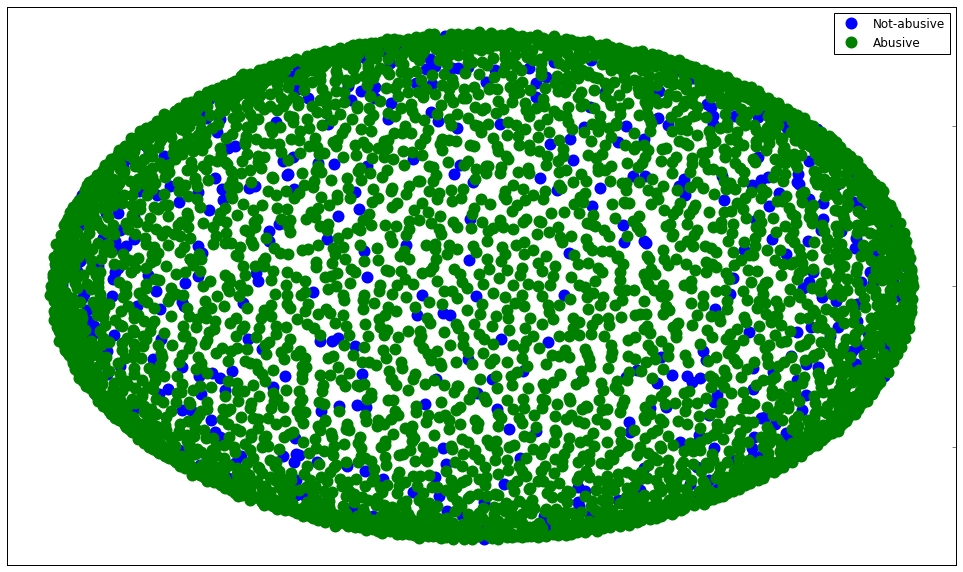

In [220]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='',ms=12, label=cluster_names[name],mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

There is no clear distinction between the 2 clusters and both the clusters contain insults indicating that the clustering was not successful.